In [4]:
import nltk

In [5]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyam/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install textblob

In [27]:
import tweepy
import pandas as pd
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

# Twitter API credentials
API_KEY = 'J8Tzjq2HOQih0yAdpxKtFRZhB'
API_SECRET_KEY = 'mbTmvSsCG50TMC1ibAi35D1IoZG35w503hCZSEKWpp2mQzg4GA'
#access_key = "1103710624582819840-59rVWMj2lxU3vgQM9j3zkfTf4VzOmY"
#access_secret = "NJMXskbkSfL7XHDSWbqYALBhn8qTqwFzAQMQQkAqoBrE9"

# authenticate Twitter API using credentials
# Authenticate with Twitter API
auth = tweepy.AppAuthHandler(API_KEY, API_SECRET_KEY)

# create tweepy API object
api = tweepy.API(auth, wait_on_rate_limit=True)

In [28]:
# define keywords and hashtags to search for
keywords = ["mental health", "mental illness", "depression", "anxiety", "stress", "mental wellness", "selfcare","therapy"] 
            #"counseling", "suicide prevention", "end the stigma", "mental health awareness","mental health matters","mindfulness","recovery", "mental health support"]
hashtags = ["#mentalhealth", "#mentalillness", "#depression", "#anxiety", "#stress", "#mentalwellness", "#selfcare","#therapy"] 
            #"#counseling", "#suicideprevention", "#endthestigma", "#mentalhealthawareness","#mentalhealthmatters","#mindfulness","#recovery", "#mentalhealthsupport"]

# Search query remove retweets from search results
search_words = " OR ".join(keywords + hashtags) + " -filter:retweets"

# preprocess tweet data
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
tokenizer = TweetTokenizer()

def clean_tweet(tweet):
    # remove links, special characters, and usernames
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    # tokenize and remove stop words
    tokens = tokenizer.tokenize(tweet)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # stem remaining tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # join stemmed tokens back into sentence
    clean_tweet = ' '.join(stemmed_tokens)
    return clean_tweet

# perform sentiment analysis using TextBlob
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# initialize list to store tweets
tweets_list = []

In [31]:
# collect tweets using Tweepy cursor
for tweet in tweepy.Cursor(api.search_tweets, q=search_words, lang='en', tweet_mode='extended').items(10000):
    # preprocess tweet text
    cleaned_tweet = clean_tweet(tweet.full_text)
    # get sentiment score
    sentiment = get_sentiment(cleaned_tweet)
    # add cleaned tweet and sentiment to list
    tweets_list.append({'Tweet': cleaned_tweet, 'Sentiment': sentiment})

# create dataframe from list of tweets
tweets_df = pd.DataFrame(tweets_list)

# print number of tweets collected
print(f"Number of tweets collected: {len(tweets_df)}")

# print number of tweets by sentiment
print("Number of tweets by sentiment:")
print(tweets_df['Sentiment'].value_counts())


Rate limit reached. Sleeping for: 428


Number of tweets collected: 17695
Number of tweets by sentiment:
negative    10770
positive     6049
neutral       876
Name: Sentiment, dtype: int64


In [33]:
# calculate percentage of tweets by sentiment
sentiment_counts = tweets_df['Sentiment'].value_counts()
percentage_positive = sentiment_counts['positive'] / len(tweets_df) * 100
percentage_neutral = sentiment_counts['neutral'] / len(tweets_df) * 100
percentage_negative = sentiment_counts['negative'] / len(tweets_df) * 100
print("Percentage of tweets by sentiment:")
print(f"Positive: {percentage_positive:.2f}%")
print(f"Neutral: {percentage_neutral:.2f}%")
print(f"Negative: {percentage_negative:.2f}%")

# calculate average sentiment score across all tweets
sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['Sentiment Score'] = tweets_df['Sentiment'].map(sentiment_scores)
average_sentiment_score = tweets_df['Sentiment Score'].mean()
print(f"Average sentiment score: {average_sentiment_score:.2f}")


Percentage of tweets by sentiment:
Positive: 34.18%
Neutral: 4.95%
Negative: 60.86%
Average sentiment score: -0.27


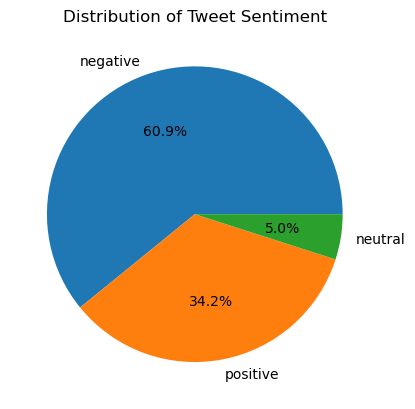

In [34]:
import matplotlib.pyplot as plt

# count the number of tweets by sentiment
sentiment_counts = tweets_df['Sentiment'].value_counts()

# create a pie chart to show the distribution of positive, negative, and neutral tweets
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Tweet Sentiment')
plt.show()


In [36]:
pip install wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


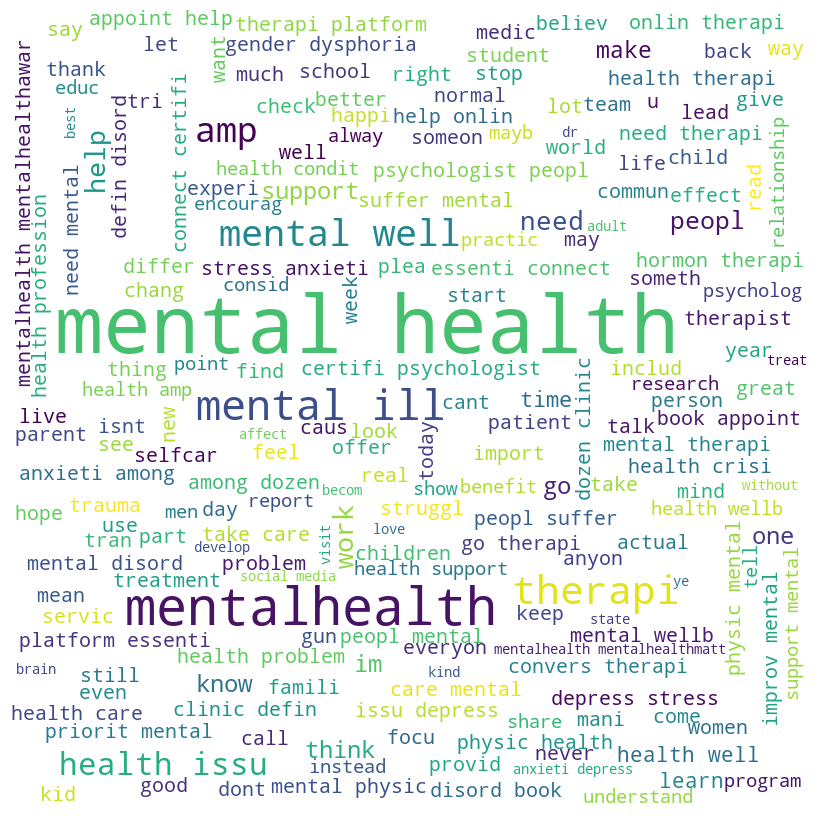

In [37]:
from wordcloud import WordCloud

# combine all tweets into a single string
all_tweets = ' '.join(tweets_df['Tweet'])

# create a word cloud from the tweets
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_tweets)

# display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [38]:
# import necessary libraries
import gensim
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint

# create a list of the cleaned tweets
cleaned_tweets = tweets_df['Tweet'].tolist()

# tokenize and create a dictionary of the tweets
tokenized_tweets = [tweet.split() for tweet in cleaned_tweets]
dictionary = corpora.Dictionary(tokenized_tweets)

# create a corpus of the tweets
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

# create the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# print the topics and their top 10 keywords
pprint(lda_model.print_topics())

# add the topic to the tweets dataframe
tweets_df['Topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]


[(0,
  '0.052*"mental" + 0.044*"health" + 0.032*"mentalhealth" + 0.015*"well" + '
  '0.012*"help" + 0.011*"amp" + 0.010*"support" + 0.008*"wellb" + '
  '0.006*"therapi" + 0.006*"improv"'),
 (1,
  '0.050*"mental" + 0.045*"health" + 0.032*"mentalhealth" + 0.015*"well" + '
  '0.009*"amp" + 0.008*"mentalhealthawar" + 0.006*"mentalhealthmatt" + '
  '0.006*"therapi" + 0.005*"peopl" + 0.004*"first"'),
 (2,
  '0.035*"mental" + 0.031*"health" + 0.031*"anxieti" + 0.030*"depress" + '
  '0.023*"stress" + 0.023*"help" + 0.021*"therapi" + 0.021*"peopl" + '
  '0.021*"disord" + 0.019*"issu"'),
 (3,
  '0.059*"mental" + 0.049*"therapi" + 0.025*"health" + 0.017*"ill" + '
  '0.015*"need" + 0.014*"peopl" + 0.009*"get" + 0.007*"help" + 0.007*"dont" + '
  '0.007*"like"'),
 (4,
  '0.056*"mental" + 0.045*"health" + 0.027*"well" + 0.025*"mentalhealth" + '
  '0.017*"selfcar" + 0.016*"take" + 0.014*"physic" + 0.012*"wellb" + '
  '0.010*"support" + 0.009*"care"')]


/Users/shreyam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


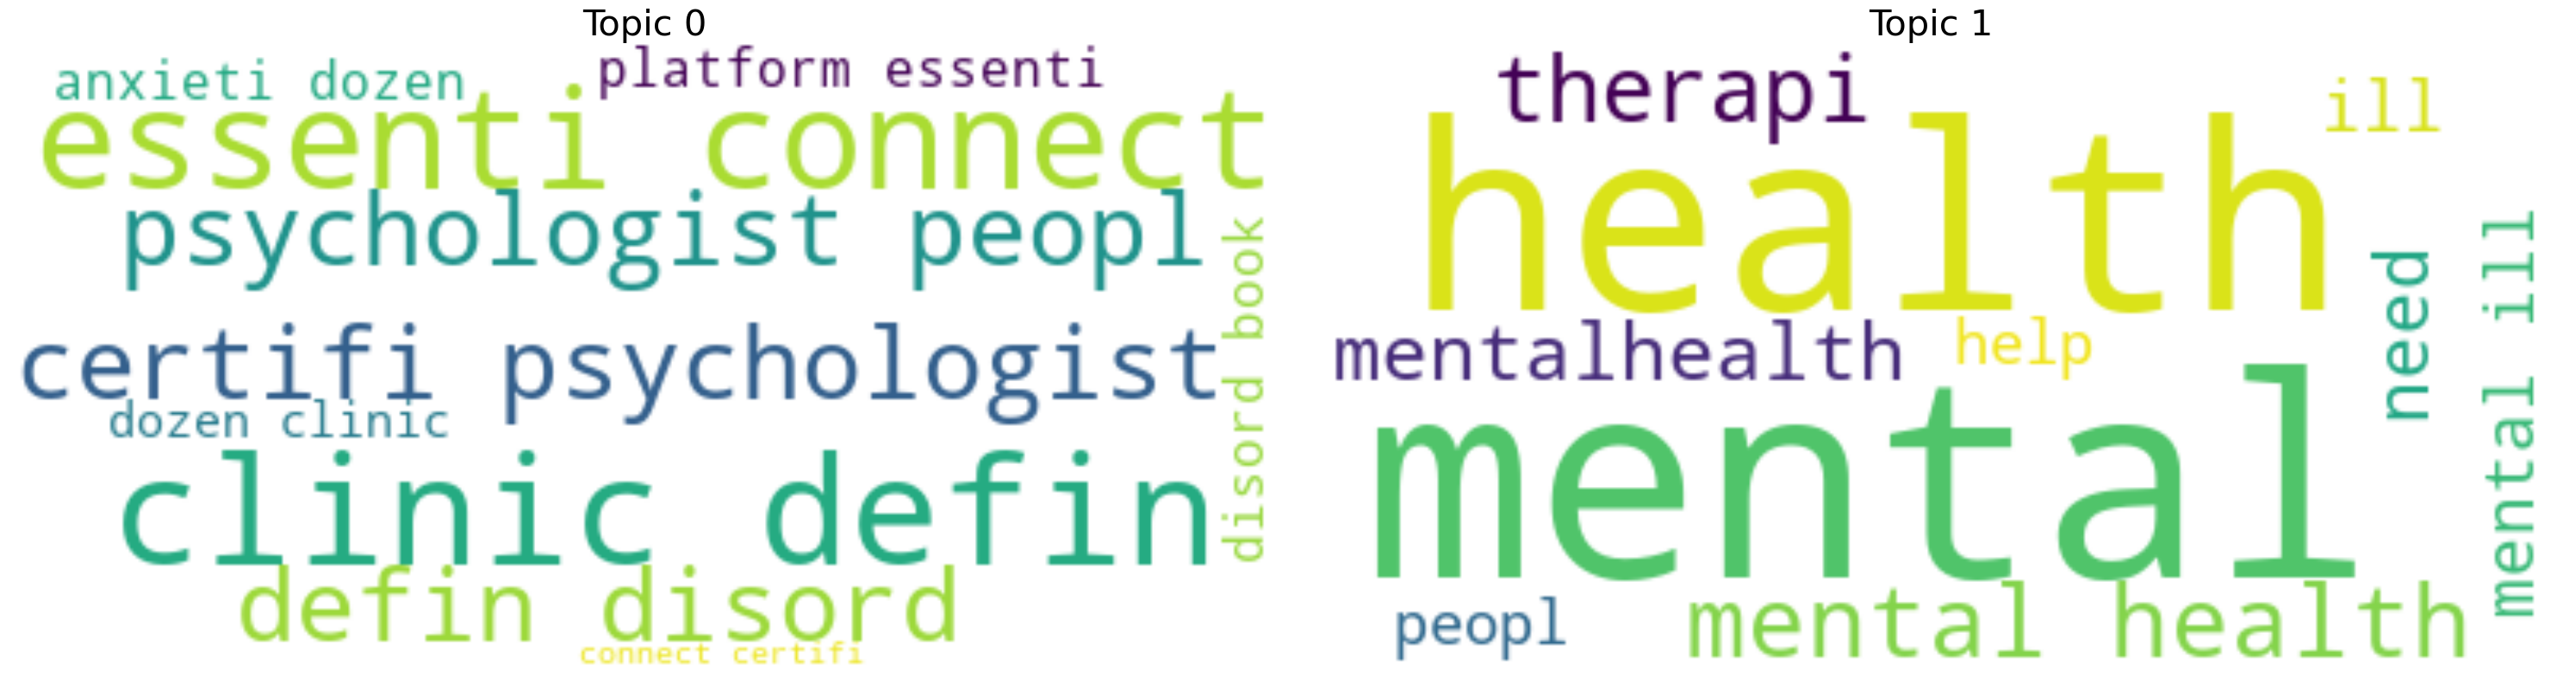

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# define function to plot word cloud for each topic
def plot_wordclouds(model, feature_names, num_top_words):
    # create subplots
    num_topics = model.n_components
    fig, axes = plt.subplots(1, num_topics, figsize=(30, 15), sharex=True, sharey=True)

    # generate word clouds for each topic
    def plot_wordclouds(model, feature_names, num_top_words):
        num_topics = len(model.components_)
        fig, axes = plt.subplots(nrows=1, ncols=num_topics, figsize=(20, 20), sharex=True, sharey=True)

    # plot word clouds for each topic
    def plot_wordclouds(model, feature_names, num_top_words):
        num_topics = model.n_components_
        fig, axes = plt.subplots(2, num_topics, figsize=(2*num_topics, 4))

    for i, ax in enumerate(axes.flatten()):
        topic = model.components_[i]
        topic_words = {feature_names[j]: topic[j] for j in topic.argsort()[:-num_top_words - 1:-1]}
        wc = WordCloud(background_color="white", max_words=num_top_words)
        wc.generate_from_frequencies(topic_words)
        ax.imshow(wc, interpolation='bilinear')
        ax.set_title('Topic ' + str(i), fontsize=30)
        ax.axis('off')


    plt.tight_layout()
    plt.show()


# perform topic modeling using NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# create tf-idf vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, ngram_range=(1,2))
tfidf = vectorizer.fit_transform(tweets_df['Tweet'])

# initialize NMF model
num_topics = 2
nmf_model = NMF(n_components=num_topics, init='nndsvd')

# fit NMF model to tf-idf features
nmf_model.fit(tfidf)

# get list of feature names
feature_names = vectorizer.get_feature_names()

# define number of top words to display for each topic
num_top_words = 10

# plot word clouds for each topic
plot_wordclouds(nmf_model, feature_names, num_top_words)



In [55]:
from gensim.models import CoherenceModel

# create list of cleaned tweets
cleaned_tweets = tweets_df['Tweet'].tolist()

# tokenize and create dictionary of tweets
tokenized_tweets = [tweet.split() for tweet in cleaned_tweets]
dictionary = corpora.Dictionary(tokenized_tweets)

# create corpus of tweets
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

# evaluate coherence score for different number of topics
coherence_scores = []
for num_topics in range(2, 11):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_tweets, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((num_topics, coherence_score))
    print(f"Number of topics: {num_topics}, coherence score: {coherence_score:.2f}")

# print coherence scores for each number of topics
print(coherence_scores)


Number of topics: 2, coherence score: 0.37
Number of topics: 3, coherence score: 0.29
Number of topics: 4, coherence score: 0.46
Number of topics: 5, coherence score: 0.49
Number of topics: 6, coherence score: 0.43
Number of topics: 7, coherence score: 0.44
Number of topics: 8, coherence score: 0.40
Number of topics: 9, coherence score: 0.37
Number of topics: 10, coherence score: 0.39
[(2, 0.369659465682562), (3, 0.2898122890605244), (4, 0.4616648379538431), (5, 0.4855847170216185), (6, 0.43155665837924834), (7, 0.44477732999109687), (8, 0.3999342500319777), (9, 0.3685015308952367), (10, 0.3852147759712832)]
